In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

This is a template for your final project. 

In [ ]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

In [ ]:
# The best measure of success for film production company is the profit they make on a film. 
# We will use ‘profit’ as a target variable. profit = worlwide_gross_income - budget
# I will drop all rows where budget or worlwide_gross_income is Null.
# Otherwise, we will not be able to calculate the value of target variable

# drop all rows where budget is null
df = full_dataset[full_dataset.budget.notnull()]

# drop all rows where worlwide_gross_income is null
df = df[df.worlwide_gross_income.notnull()]

df.shape

(9174, 22)

In [ ]:
# clean all money columns - remove currency signs

df['cleaned_b'] = df['budget'].str.split()
df['cleaned_wgi'] = df['worlwide_gross_income'].str.split()
df['cleaned_ugi'] = df['usa_gross_income'].str.split()

# All World and US incomes are measured in $ but some budgets are measures in other currencies.
# We can't easily convert these numbers to $ so we will drop rows with not $ budgets

# df['cleaned_b'].str[0].value_counts()
# df['cleaned_wgi'].str[0].value_counts()
# df['cleaned_ugi'].str[0].value_counts()

df = df[df.cleaned_b.str[0].str.strip() == '$']   # drop all non dollar values

df['profit'] = (df.cleaned_wgi.str[1]).astype(float) - (df.cleaned_b.str[1]).astype(float)
df['usa_g_income'] = (df.cleaned_ugi.str[1]).astype(float)

df = df.drop(columns=['budget', 'worlwide_gross_income', 'usa_gross_income', 'cleaned_b', 'cleaned_wgi', 'cleaned_ugi'])

In [ ]:
df.shape

(7115, 21)

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

In [ ]:
# This is a skewed distribution. We can't even use log scale.

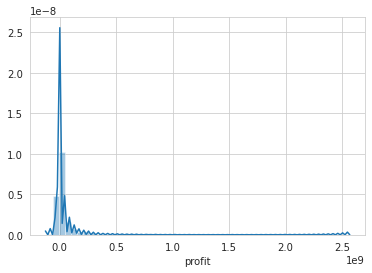

In [ ]:
sns.distplot(df['profit'])

In [ ]:
# The next best thing we can predict for the business is in what bucket a movie will fall.
# Will it lose money, make little money (< 50M), make some money or make lots of money (> 200M).
# Let's calculate a new target variable - rank

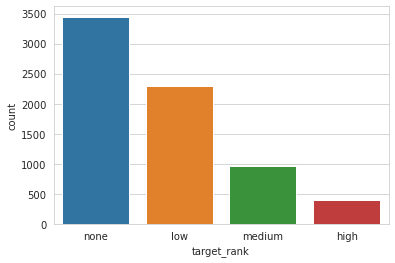

In [ ]:
bins = [df['profit'].min() - 1, 0, 50000000, 200000000, df['profit'].max() + 1]
names = ['none', 'low', 'medium', 'high']

df['target_rank'] = pd.cut(df['profit'], bins, labels=names)

def target_rank_trans(t):
    target_trans_dict = {'none': 0,
                      'low': 1,
                      'medium': 2,
                      'high': 3}
    return target_trans_dict[t]

df['rank'] = df['target_rank'].apply(target_rank_trans)

sns.countplot(x=df['target_rank'], data=df)

In [ ]:
# rank is a ordinal variable so we will use classification

df = df.drop(columns=['profit', 'target_rank'])

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

In [ ]:
# I will use F1 metric

from sklearn.metrics import f1_score

### Part 2.

Explore and preprocess the data

2.1 Split data into train and test

In [ ]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(df, test_size=0.4, random_state=42)

y_train = tr['rank']
y_valid = val['rank']
X_train = tr.drop(['rank'], axis=1)
X_valid = val.drop(['rank'], axis=1)

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


In [ ]:
tr.shape

(4269, 21)

In [ ]:
tr.nunique()

imdb_title_id           4269
title                   4228
original_title          4228
year                      91
date_published          2476
genre                    372
duration                 138
country                  571
language                 590
director                2439
writer                  3814
production_company      1850
actors                  4268
description             4251
avg_vote                  72
votes                   4063
metascore                 95
reviews_from_users       843
reviews_from_critics     465
usa_g_income            3613
rank                       4
dtype: int64

In [ ]:
# Drop columns which have all or almost all unique values - nothing to learn
unique_val_cols = ['imdb_title_id', 'original_title', 'title', 'description']

def drop_cols(data, cols):
    return data.drop(columns=cols)

In [ ]:
X_train = drop_cols(X_train, unique_val_cols)
X_valid = drop_cols(X_valid, unique_val_cols)

In [ ]:
# Check categorical fields

In [ ]:
# Check genre

from sklearn.feature_extraction.text import CountVectorizer

def process_genre(data):
    
    data['genre'] = data['genre'].str.replace('-','')
        
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data['genre'].tolist())
    b = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index= data.index)
    data = data.join(b)
    return data

X_train = process_genre(X_train)
X_valid = process_genre(X_valid)

<Figure size 432x288 with 0 Axes>

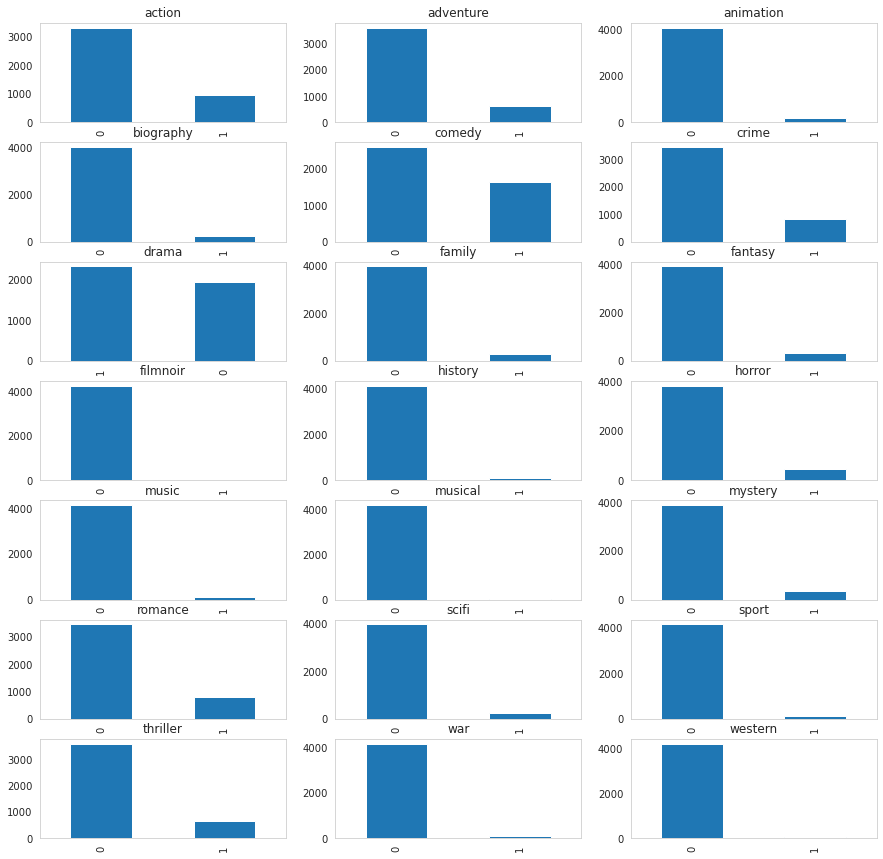

In [ ]:
def show_genre_cols(data):
    cols = ['action', 'adventure',
       'animation', 'biography', 'comedy', 'crime', 'drama', 'family',
       'fantasy', 'filmnoir', 'history', 'horror', 'music', 'musical',
       'mystery', 'romance', 'scifi', 'sport', 'thriller', 'war', 'western']

    plt.figure()
    f, ax = plt.subplots(7, 3, figsize=(15, 15))

    for i, c in enumerate(cols):
        plt.subplot(7,3,i+1)

        data[c].value_counts().plot(kind='bar')
        plt.title(c)
        plt.grid()
        
    plt.show()
    
show_genre_cols(X_train)

In [ ]:
genre_cols =['genre', 'animation', 'biography', 'war', 'western', 'music', 'musical', 'history', 'scifi', 'sport', 'filmnoir']
X_train = drop_cols(X_train, genre_cols)
X_valid = drop_cols(X_valid, genre_cols)

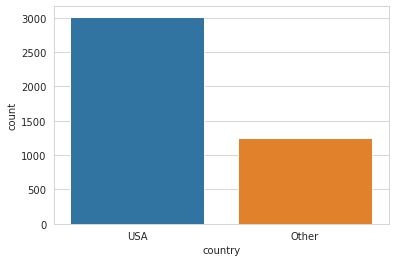

In [ ]:
# Check country

def process_country(data):
    
    countries = ['USA']
    data['country'] = data['country'].str.split(',').str[0]
    
    data.loc[~data['country'].isin(countries), 'country'] = 'Other'
    
    return data

X_train = process_country(X_train)
X_valid = process_country(X_valid)

sns.countplot(x='country', data=X_train)

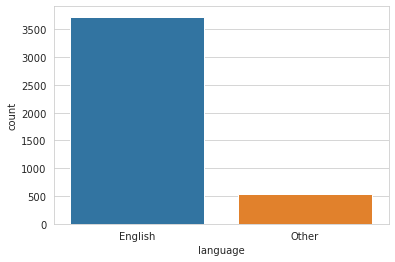

In [ ]:
# Check language

def process_lang(data):
    
    lang = ['English']
    data['language'] = data['language'].str.split(',').str[0]
    
    data.loc[~data['language'].isin(lang), 'language'] = 'Other'
    
    return data

X_train = process_lang(X_train)
X_valid = process_lang(X_valid)

sns.countplot(x='language', data=X_train)

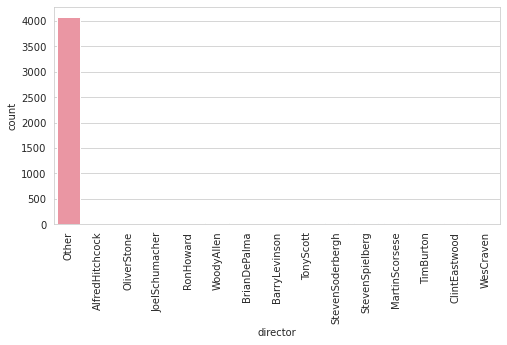

In [ ]:
# Process director - check top 15 directors

def process_dir(data):
    
    director = ['WoodyAllen','StevenSoderbergh','MartinScorsese','ClintEastwood','StevenSpielberg','BrianDePalma','JoelSchumacher',
             'TonyScott','RonHoward','AlfredHitchcock','WesCraven','OliverStone','BarryLevinson','TimBurton']
    
    data['director'] = data['director'].str.split(',').str[0].str.replace(' ', '')
    
    data.loc[~data['director'].isin(director), 'director'] = 'Other'
    
    return data

X_train = process_dir(X_train)
X_valid = process_dir(X_valid)

plt.figure(figsize=(8,4))
sns.countplot(x='director', data=X_train)
plt.xticks(rotation=90);


In [ ]:
cat_cols = ['director', 'actors', 'writer']
X_train = drop_cols(X_train, cat_cols)
X_valid = drop_cols(X_valid, cat_cols)

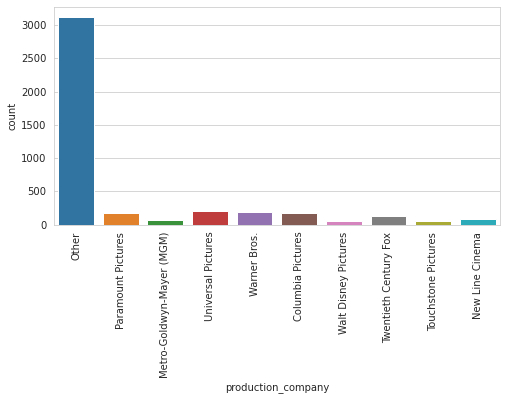

In [ ]:
# check production_company

def process_prod_comp(data):
    
    prod_comp = ['Universal Pictures', 'Warner Bros.', 'Paramount Pictures', 'Columbia Pictures',
               'Twentieth Century Fox','New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Walt Disney Pictures',
               'Touchstone Pictures']
    
    data['production_company'] = data['production_company'].str.split(',').str[0]
    
    data.loc[~data['production_company'].isin(prod_comp), 'production_company'] = 'Other'
    
    return data

X_train = process_prod_comp(X_train)
X_valid = process_prod_comp(X_valid)

plt.figure(figsize=(8,4))
sns.countplot(x='production_company', data=X_train)
plt.xticks(rotation=90);


In [ ]:
# Check numerical columns

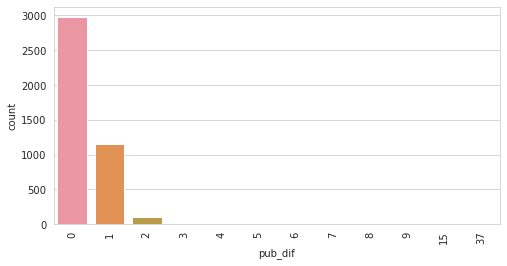

In [ ]:
# Check dates - delay in release may have impact on success

def process_dates(data):
    
    data['pub_dif'] = data['date_published'].str.split('-').str[0].astype(int) - data['year'].astype(int)
    
    return data

X_train = process_dates(X_train)
X_valid = process_dates(X_valid)

plt.figure(figsize=(8,4))
sns.countplot(x='pub_dif', data=X_train)
plt.xticks(rotation=90);

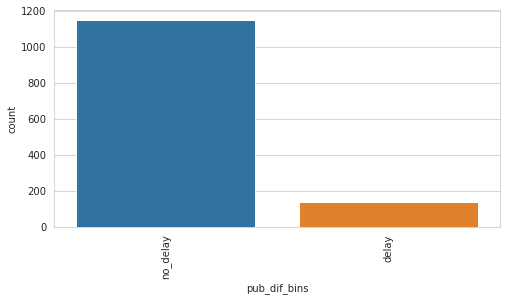

In [ ]:
bins = [0, 1, 38]
names = ['no_delay', 'delay']

X_train['pub_dif_bins'] = pd.cut(X_train['pub_dif'], bins, labels=names)
X_valid['pub_dif_bins'] = pd.cut(X_valid['pub_dif'], bins, labels=names)

plt.figure(figsize=(8,4))
sns.countplot(x='pub_dif_bins', data=X_train)
plt.xticks(rotation=90);

In [ ]:
date_cols = ['year', 'date_published', 'pub_dif']
X_train = drop_cols(X_train, date_cols)
X_valid = drop_cols(X_valid, date_cols)

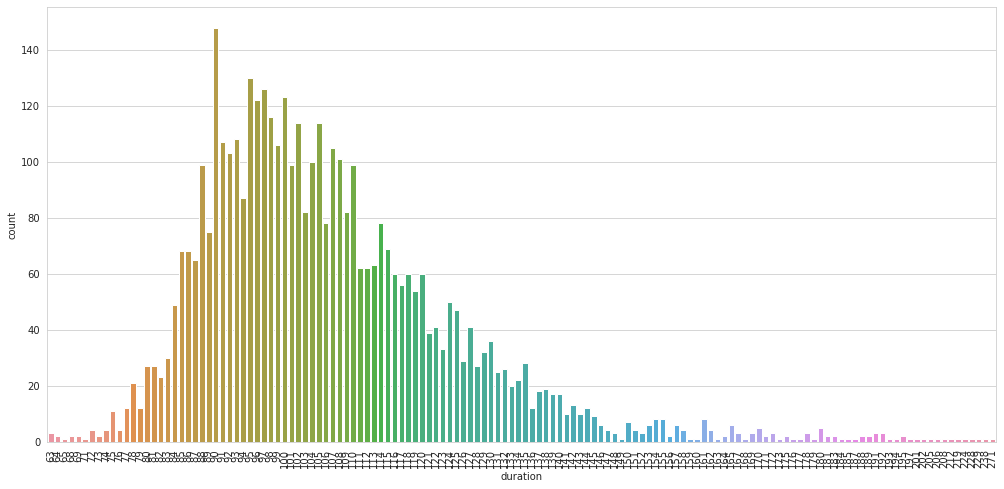

In [ ]:
# Process duration

plt.figure(figsize=(17,8))
sns.countplot(x='duration', data=X_train)
plt.xticks(rotation=90);

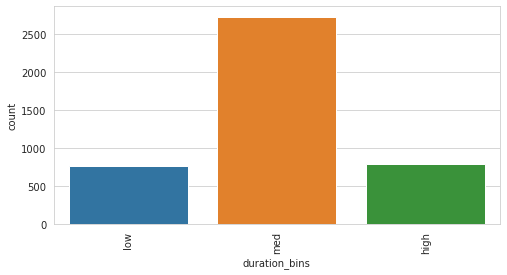

In [ ]:
bins = [62, 90, 120, 272]
names = ['low', 'med', 'high']

X_train['duration_bins'] = pd.cut(X_train['duration'], bins, labels=names)
X_valid['duration_bins'] = pd.cut(X_valid['duration'], bins, labels=names)

plt.figure(figsize=(8,4))
sns.countplot(x='duration_bins', data=X_train)
plt.xticks(rotation=90);

In [ ]:
duration_cols = ['duration']
X_train = drop_cols(X_train, duration_cols)
X_valid = drop_cols(X_valid, duration_cols)

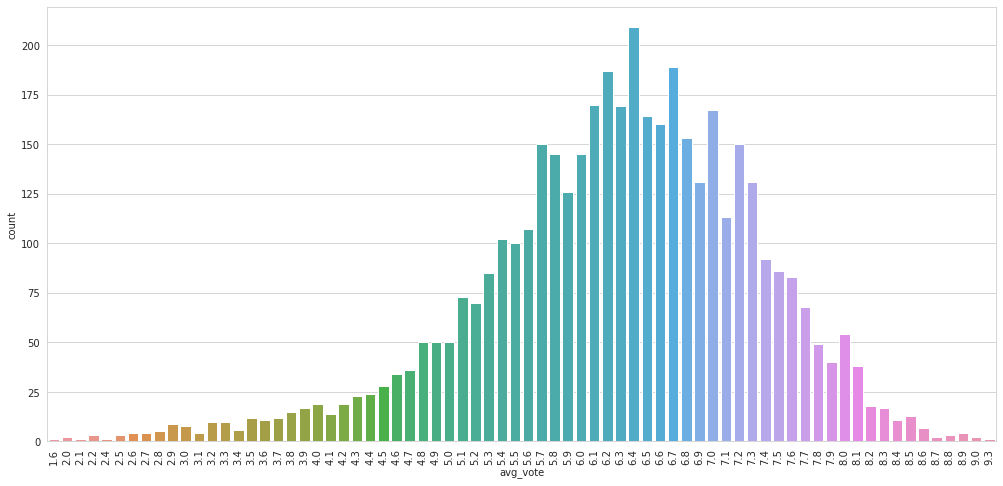

In [ ]:
# Avg vote and votes 

plt.figure(figsize=(17,8))
sns.countplot(x='avg_vote', data=X_train)
plt.xticks(rotation=90);

In [ ]:
X_train['score'] = (X_train['avg_vote'] * X_train['votes']).astype(int)
X_valid['score'] = (X_valid['avg_vote'] * X_valid['votes']).astype(int)

In [ ]:
vote_cols = ['votes', 'avg_vote']
X_train = drop_cols(X_train, vote_cols)
X_valid = drop_cols(X_valid, vote_cols)

In [ ]:
# Check usa income

X_train['usa_g_income'] = np.round(np.log(X_train['usa_g_income']), decimals=6)
X_valid['usa_g_income'] = np.round(np.log(X_valid['usa_g_income']), decimals=6)

In [ ]:
X_train.head(5)

,country,language,production_company,metascore,reviews_from_users,reviews_from_critics,usa_g_income,action,adventure,comedy,...,drama,family,fantasy,horror,mystery,romance,thriller,pub_dif_bins,duration_bins,score
29264,USA,English,Other,NaN,5.0,4.0,10.871706,0,0,0,...,1,0,0,0,0,0,0,no_delay,med,710
20601,USA,English,Paramount Pictures,64.0,199.0,123.0,19.274076,1,0,1,...,0,0,0,0,0,0,0,no_delay,med,1109322
54879,Other,Other,Other,NaN,NaN,NaN,NaN,0,0,1,...,1,0,0,0,0,0,0,NaN,med,812
4564,USA,English,Metro-Goldwyn-Mayer (MGM),NaN,159.0,103.0,NaN,0,0,1,...,1,1,0,0,0,0,0,no_delay,med,141823
50614,Other,Other,Other,NaN,2.0,NaN,NaN,0,0,1,...,1,0,0,0,0,0,0,NaN,med,730


In [ ]:
#X_valid.columns
#X_valid.shape
#X_train.columns
#X_train.shape
#X_train.dtypes
X_train.isnull().sum()

country                    0
language                   0
production_company         0
metascore               1262
reviews_from_users        40
reviews_from_critics      37
usa_g_income             646
action                     0
adventure                  0
comedy                     0
crime                      0
drama                      0
family                     0
fantasy                    0
horror                     0
mystery                    0
romance                    0
thriller                   0
pub_dif_bins            2977
duration_bins              0
score                      0
dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# define the preprocessings for each group of features

categ_prep = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

num_prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [ ]:
from sklearn.compose import ColumnTransformer

categorical_cols = ['country', 'language', 'production_company', 'pub_dif_bins', 'duration_bins']
numerical_cols = ['metascore', 'reviews_from_users', 'reviews_from_critics', 'usa_g_income', 'score']

# define column transformer
column_transforms = ColumnTransformer([
    ('cat', categ_prep, categorical_cols),
    ('num', num_prep, numerical_cols)
], remainder='passthrough')

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model1 = Pipeline([
    ('transform', column_transforms),
    ('LR', LogisticRegression(multi_class='multinomial'))
])

model1.fit(X_train, y_train)
y_valid_pred = model1.predict(X_valid)
print('Logistic Regression', f1_score(y_valid, y_valid_pred, average='micro'))

Logistic Regression 0.7157413914265635


In [ ]:
from sklearn.svm import SVC

model2 = Pipeline([
    ('transform', column_transforms),
    ('SVM', SVC())
])

model2.fit(X_train, y_train)
y_valid_pred = model2.predict(X_valid)
print('SVM', f1_score(y_valid, y_valid_pred, average='micro'))


SVM 0.7203092059030218


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model3 = Pipeline([
    ('transform', column_transforms),
    ('RF', RandomForestClassifier())
])

model3.fit(X_train, y_train)
y_valid_pred = model3.predict(X_valid)
print('Randon Forest', f1_score(y_valid, y_valid_pred, average='micro'))

Randon Forest 0.7572030920590302


3.2 Use cross-validation to compare models and select best set of hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

f1_macro = make_scorer(f1_score , average='macro')

param_grid = { 
    'LR__solver': ['newton-cg'],
    'LR__penalty': ['l2'],
    'LR__tol': [0.0001]
}

LR_gs = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring=f1_macro, n_jobs=-1)
LR_gs.fit(X_train, y_train)
print('LR best score', LR_gs.best_score_)
LR_gs.best_params_

LR best score 0.7071704094599968


{'LR__penalty': 'l2', 'LR__solver': 'newton-cg', 'LR__tol': 0.0001}

In [ ]:
f1_macro = make_scorer(f1_score , average='macro')

param_grid = { 
    'SVM__kernel': ['poly'],
    'SVM__degree': [2],
    'SVM__coef0' : [4],
    'SVM__C' :[2]
}

SVC_gs = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring=f1_macro, n_jobs=-1)
SVC_gs.fit(X_train, y_train)
print('SVM best score', SVC_gs.best_score_)
SVC_gs.best_params_

SVM best score 0.7214541510595374


{'SVM__C': 2, 'SVM__coef0': 4, 'SVM__degree': 2, 'SVM__kernel': 'poly'}

In [ ]:
f1_macro = make_scorer(f1_score , average='macro')

param_grid = { 
    'RF__criterion': ['gini'],
    'RF__max_depth': [200],
    'RF__n_estimators': [300, 350, 450]
}

RF_gs = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5, scoring=f1_macro, n_jobs=-1)
RF_gs.fit(X_train, y_train)
print('SVM best score', RF_gs.best_score_)
RF_gs.best_params_

SVM best score 0.7482818812475134


{'RF__criterion': 'gini', 'RF__max_depth': 200, 'RF__n_estimators': 450}

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

In [ ]:
# Randon Forest is the best model

# Random Forest has F1 score of 0.7572 on the test data set

# This model predicts what movie will have commercial success as compared to other movies. 
# Commercial success defined as: movie will lose money, it will break even (make between 0-49M),
# it will make lots of money (50-199M) or it will be hugely successful and make more than 200M in revenues.